In [ ]:
# google colab で実行する場合は以下のコメントアウトを外す
# ! wget https://indexes.nikkei.co.jp/nkave/historical/nikkei_stock_average_daily_jp.csv
# ! pip install statsmodels==0.13.1
# ! pip install pmdarima

In [1]:
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm

In [26]:
# 日経平均株価のデータフレームを作成
# (最後の行の利用方法の説明は、skipfooter=1 でデータフレームに取り込まない)
stock_df = pd.read_csv('nikkei_stock_average_daily_jp.csv', encoding='cp932', skipfooter=1, engine='python')['終値']

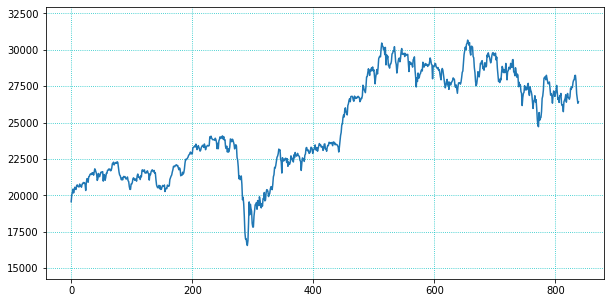

In [27]:
# 日経平均株価のグラフを表示
fig = plt.figure(figsize=(10,5))  
ax = fig.add_subplot(111)
ax.plot(stock_df)
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min * 0.9, y_max * 1.05)
ax.grid(axis='both',linestyle='dotted', color='c')

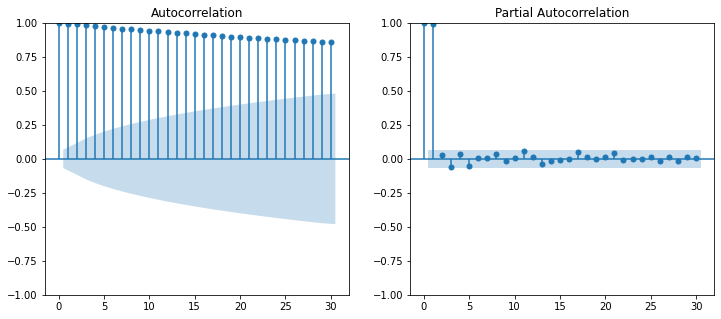

In [28]:
# 自己相関係数と偏自己相関係数のグラフを表示
fig = plt.figure(figsize=(12, 5))  
ax1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(stock_df, ax=ax1)
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(stock_df, ax=ax2, method='ywm')

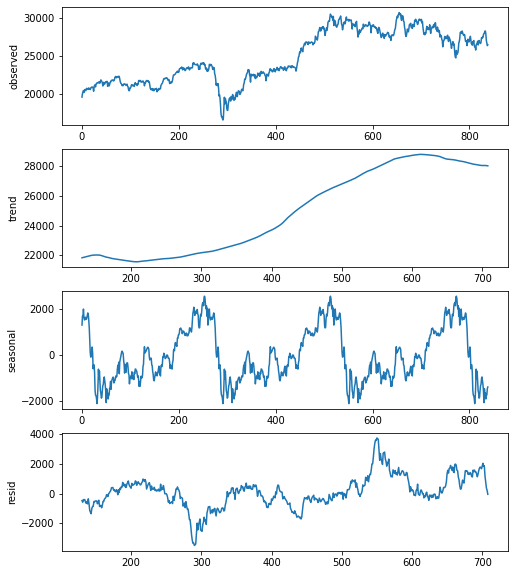

In [29]:
# 時系列データをトレンド、規則的変動成分、不規則変動成分に分解
# 260=5*52
res = sm.tsa.seasonal_decompose(stock_df, period=260) 
fig = plt.figure(figsize=(8, 10))
ax1 = fig.add_subplot(411)
ax1.set_ylabel('observed')
ax1.plot(res.observed)
ax2 = fig.add_subplot(412)
ax2.set_ylabel('trend')
ax2.plot(res.trend)
ax3 = fig.add_subplot(413)
ax3.set_ylabel('seasonal')
ax3.plot(res.seasonal)
ax4 = fig.add_subplot(414)
ax4.set_ylabel('resid')
ax4.plot(res.resid)


In [21]:
# モデル構築と検証のためのデータを準備
train = stock_df[0:800]  # 学習用データ 
test = stock_df[800:]  # 検証用データ 

In [22]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(train, 
                          seasonal=True, 
                          trace=True, 
                          m=5, 
                          stepwise=True)                         
stepwise_fit.summary()

# m=260 ARIMA(1,1,1)(0,0,0)[260] intercept   : AIC=11419.268
# m=25  ARIMA(2,1,1)(0,0,1)[25]             : AIC=11409.334
# m=5   ARIMA(2,1,1)(0,0,2)[5]             : AIC=11414.791

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=11418.406, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=11420.968, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=11424.198, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=11424.109, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=11419.666, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=11420.541, Time=0.52 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=11420.543, Time=0.45 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=11418.238, Time=1.09 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=11418.285, Time=0.73 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=11419.423, Time=1.18 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=11418.068, Time=0.84 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=11417.848, Time=0.45 sec
 ARIMA(1,1,2)(0,0,2)[5] intercept   : AIC=11416.513, Time=0.51 sec
 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=11419.030, Time=0.29 sec
 ARIMA(1,1,2)(1,0,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  800
Model:             SARIMAX(2, 1, 1)x(0, 0, [1, 2], 5)   Log Likelihood               -5701.396
Date:                                Mon, 20 Jun 2022   AIC                          11414.791
Time:                                        07:29:24   BIC                          11442.891
Sample:                                             0   HQIC                         11425.587
                                                - 800                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7359      0.126     -5.860      0.000      -0.982      -0.490
ar.L2          0.0852      0.030      2.832      0.005       0.026       0.144
ma.L1          0.7478      0.127      5.905      0.000       0.500       0.996
ma.S.L5        0.0172      0.033      0.521      0.602      -0.048       0.082
ma.S.L10      -0.0804      0.032     -2.552      0.011      -0.142      -0.019
sigma2      9.316e+04   3490.942     26.686      0.000    8.63e+04       1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               102.03
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

800    26783.241707
801    26799.444439
802    26857.616281
803    26833.801155
804    26855.329407
805    26882.859927
806    26850.624359
807    26818.242434
808    26830.694896
809    26848.956191
810    26852.969593
811    26851.571168
812    26852.942122
813    26851.814087
814    26852.761009
815    26851.968063
816    26852.632267
817    26852.075922
818    26852.541925
819    26852.151594
820    26852.478541
821    26852.204686
822    26852.434071
823    26852.241934
824    26852.402871
825    26852.268068
826    26852.380981
827    26852.286403
828    26852.365623
829    26852.299268
830    26852.354848
831    26852.308293
832    26852.347288
833    26852.314625
834    26852.341984
835    26852.319068
836    26852.338263
837    26852.322185
838    26852.335652
Name: predicted_mean, dtype: float64


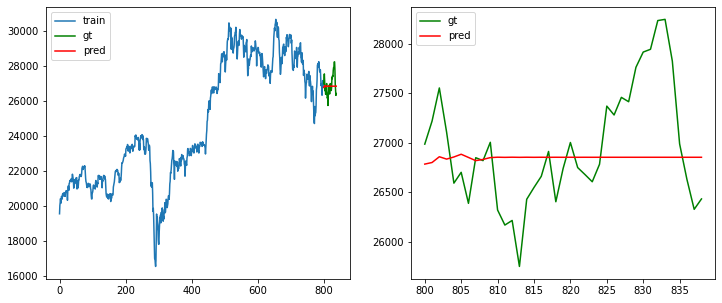

In [25]:
# train['終値'] = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
SARIMA = sm.tsa.SARIMAX(train, order=(2, 1, 1), seasonal_order=(0, 0, 2, 5)).fit()
pred = SARIMA.predict(800, 838)
print(pred)
# 実データと予測結果の図示
fig = plt.figure(figsize=(12, 5))  
ax1 = fig.add_subplot(121)
ax1.plot(train, label="train")
ax1.plot(test, "g", label="gt")
ax1.plot(pred, "r", label="pred")
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(test, "g", label="gt")
ax2.plot(pred, "r", label="pred")
ax2.legend()